In [7]:
import scipy.stats as sts
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.integrate import quad
from time import time
from numba import njit
import matplotlib.pyplot as plt


np.random.seed(0)
def timer_func(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

# Estimators
def nonParametricOptimalQuantity(distributionData, tau):
    optimalQuantity = np.quantile(distributionData,tau)
    return optimalQuantity

def parametricOptimalQuantity(tau, dist, parameters):
    optimalQuantity = dist.ppf(tau, *parameters)
    return optimalQuantity

def realParamatricOptimalQuantity(tau, realDist):
    optimalQuantity = realDist.ppf(tau)
    return optimalQuantity

# Optimized code for integrating the lognormal distribution (very quickly), @njit is compiling the python code to C

@njit
def lognormal_pdf(x, shape, location, scale):
    mu = np.log(scale)
    sigma = shape
    if x <= 0:
        return 0
    exponent = -(np.log(x) - mu)**2 / (2 * sigma**2)
    coefficient = 1 / (x * sigma * np.sqrt(2 * np.pi))
    return x * coefficient * np.exp(exponent)

def integrate_normal(Q_star,parameters):
    return quad(lognormal_pdf,0,Q_star,args=(parameters[0], parameters[1],parameters[2]))[0]

############################################################

def calculateOptimalProfit(tau,Q_star,dist, paramaters):
    price = 1
    cost = 1 - tau

    integral_value = integrate_normal(Q_star, paramaters)
    t1 = price * integral_value
    t2 = price * Q_star * dist.sf(Q_star)
    t3 = cost * Q_star
    return t1 + t2 - t3

# Evaluation of test statistics functions
def empericalRootMeanSquaredError(m, optimalQuantities, realOptimalQuantity):
    rmse = np.sqrt(1/m * np.sum((optimalQuantities - realOptimalQuantity)**2))
    return rmse

def empericalRootMeanSquaredErrorRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, realOptimalQuantity):
    return empericalRootMeanSquaredError(m, nonParametricOptimalQuantitys, realOptimalQuantity) / empericalRootMeanSquaredError(m, parametricOptimalQuantitys, realOptimalQuantity)

def empericalProfitLoss(m, profitEstimator, profitReal):
    return 1 / m * np.sum(np.abs((profitReal - profitEstimator) /  profitReal))

def empericalProfitLossRatio(m, parametricExpectedProfit, nonParametricExpectedProfit, realExpectedProfit):
    return empericalProfitLoss(m, nonParametricExpectedProfit, realExpectedProfit) / empericalProfitLoss(m, parametricExpectedProfit, realExpectedProfit)

def empericalServiceLevel(m, optimalQuantities, demand):
    indicatorFunction = np.where(optimalQuantities.T >= demand.T, 1, 0)
    return 1 / m * np.sum(indicatorFunction)

def fit(feature):
    return np.mean(feature), np.std(feature)

def monteCarlo(m, tau, n, params):
    # Distribution that the paramatric estimator will be using
    dist = sts.norm
    # How the data is really distributed, when changing remember to change the PDF for the @njit precompiled function.
    distReal = sts.lognorm(*params)

    demand = np.empty((m,1))
    realOptimalQuantity = np.empty((m,1))
    parametricOptimalQuantitys = np.empty((m,1))
    nonParametricOptimalQuantitys = np.empty((m,1))
    allParameters = np.empty((m,2))
    parametricExpectedProfits = np.empty((m,1))
    nonParametricExpectedProfits = np.empty((m,1))
    empericalServiceLevelData = np.empty((m,1))

    # Compute estimators and optimal quantities
    for j in range(m):
        distributionData = sts.lognorm.rvs(*params, size = n)
        empericalServiceLevelData[j] = distributionData[-1]

        allParameters[j] = parameters = fit(distributionData)
        demand[j] = parameters[0] # in case of a normal distribution
        parametricOptimalQuantitys[j] = parametricOptimalQuantity(tau, dist, parameters)
        nonParametricOptimalQuantitys[j] = nonParametricOptimalQuantity(distributionData, tau)
    
        # We use Numba to compile the python code to C, this operation usually takes a lot of time.
        parametricExpectedProfits[j] = calculateOptimalProfit(tau, parametricOptimalQuantitys[j], distReal, params)
        nonParametricExpectedProfits[j] = calculateOptimalProfit(tau, nonParametricOptimalQuantitys[j], distReal, params)
    
    
    realOptimalQuantity = realParamatricOptimalQuantity(tau, distReal)
    realExpectedProfit = calculateOptimalProfit(tau, realOptimalQuantity, distReal, params)

    eplr = empericalProfitLossRatio(m, parametricExpectedProfits, nonParametricExpectedProfits, realExpectedProfit)

    # Compute evaluation statistics
    rmse = empericalRootMeanSquaredErrorRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, realOptimalQuantity)
    eslParametric = empericalServiceLevel(m, parametricOptimalQuantitys, empericalServiceLevelData)
    eslNonParametric = empericalServiceLevel(m, nonParametricOptimalQuantitys, empericalServiceLevelData)
    
    result = {
                    'MonteCarlo iterations' : m,
                    'Sample Size': n,
                    'Target Service Level': tau,
                    'Param Values': np.mean(allParameters, axis=0),
                    #'real optimal quantity' : realOptimalQuantity,
                    #'Parm optimal quantity': np.mean(parametricOptimalQuantitys),
                    #'nonParm optimal quantity': np.mean(nonParametricOptimalQuantitys),
                    #'real optimal profit' : realExpectedProfit,
                    #'Parm optimal profit': np.mean(parametricExpectedProfits),
                    #'nonParm optimal profit': np.mean(nonParametricExpectedProfits),
                    'RMSE Ratio': rmse,
                    'SL nonParam': eslParametric,
                    'SL Param': eslNonParametric,
                    'EPLR': eplr
                }
    return result

Here we are plotting the lognormal distribution used here against the distribution from part 3

Lognorm normal parameters: mu: 4.8283137373023015, sigma: 0.2


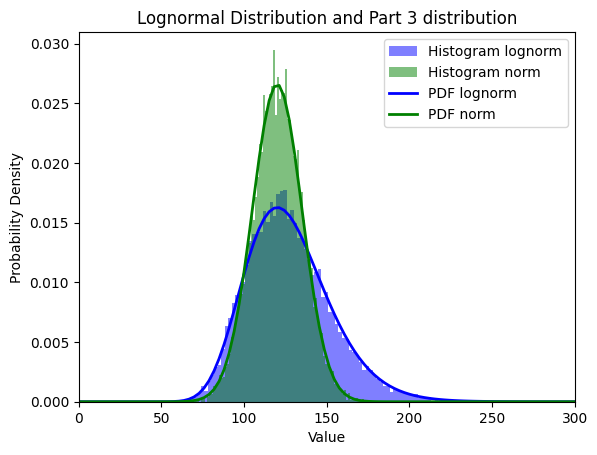

In [8]:
params = [0.2, 0, 125]
print("Lognorm normal parameters: mu: {0}, sigma: {1}".format(np.log(params[2]),params[0]))

dist = sts.lognorm(s=params[0], loc=params[1], scale=params[2])
normdist = sts.norm(loc=120, scale=15)

data = dist.rvs(size=10000)
data2 = normdist.rvs(size=10000)

plt.hist(data, bins=100, density=True, alpha=0.5, color='b', label='Histogram lognorm')
plt.hist(data2, bins=100, density=True, alpha=0.5, color='g', label='Histogram norm')

x = np.linspace(0, 300, 100)
pdf_lognorm = dist.pdf(x)
pdf_norm = normdist.pdf(x)
plt.plot(x, pdf_lognorm, 'b', linewidth=2, label='PDF lognorm')
plt.plot(x, pdf_norm, 'g', linewidth=2, label='PDF norm')

plt.title('Lognormal Distribution and Part 3 distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.xlim([0, 300])

plt.legend()
#plt.savefig("Excercise part 4/excercise4.pdf")
plt.show()

In [9]:
numberOfMontecarloIterations = 1000
params = [0.2, 0, 125]

tauArray = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
nArray = [10, 50, 100, 200]

results = []
for tau in tauArray:
    for n in nArray:
        result = monteCarlo(numberOfMontecarloIterations, tau, n, params)
        results.append(result)


UnboundLocalError: cannot access local variable 'distributionData' where it is not associated with a value

In [ ]:
df = pd.DataFrame(results)
df

,MonteCarlo iterations,Sample Size,Target Service Level,Param Values,RMSE Ratio,SL nonParam,SL Param,EPLR
0,1000,10,0.01,"[127.36080321029412, 23.49388969511495]",1.209935,0.0,0.000,5.469719
1,1000,50,0.01,"[127.49146564093148, 25.245083057452888]",0.659671,0.0,0.000,1.350387
2,1000,100,0.01,"[127.77429548232526, 25.561922724589472]",0.520076,0.0,0.000,0.671840
3,1000,200,0.01,"[127.53874411549678, 25.666672163156587]",0.367807,0.0,0.000,0.272444
4,1000,10,0.05,"[127.65471439187664, 23.68437532548774]",1.092239,0.0,0.000,1.885508
5,1000,50,0.05,"[127.57374969330489, 25.313219584309717]",0.857707,0.0,0.000,1.082942
6,1000,100,0.05,"[127.66301458825494, 25.600855304334452]",0.667075,0.0,0.000,0.599604
7,1000,200,0.05,"[127.53766545263895, 25.657291790492742]",0.506071,0.0,0.000,0.314910
8,1000,10,0.10,"[127.25556719788759, 23.52801542823624]",1.132533,0.0,0.000,1.535822
9,1000,50,0.10,"[127.58953999593064, 25.244480582490468]",1.097311,0.0,0.000,1.396166


In [ ]:
import plotly.express as px
fig = px.scatter(df, x='Target Service Level', y='RMSE Ratio', color="Sample Size", title="TSL vs RMSE, m = {0},incorrectly specified model<br><sup>higher RMSE means parametric performs better</sup>".format(numberOfMontecarloIterations))
fig.update_layout(font_size = 15)
#fig.write_image("Excercise part 4/RMSE-lognorm.pdf")
fig.show()

fig = px.scatter(df, x='Target Service Level', y='EPLR', color="Sample Size", title="TSL vs EPLR, m = {0}, incorrectly specified model<br><sup>higher EPLR means parametric performs better</sup>".format(numberOfMontecarloIterations))
fig.update_layout(font_size = 15)
#fig.write_image("Excercise part 4/EPLR-lognorm.pdf")
fig.show()